<a href="https://colab.research.google.com/github/kishorek0344/Hackathon-Project-Idea-Implementation/blob/main/Hackathon_Project_Idea_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project Title: Innovative Hackathon on Cyber Safety for Women: Unique Image ID for Tracking and Deletion**

**Problem Statement** Cyber safety is a significant concern, especially for women, who are often the targets of cybercrimes like image-based abuse. When private images are leaked or shared without consent, the repercussions can be devastating. Traditional methods of tracking and deleting such images are inadequate, as images can be quickly disseminated across multiple platforms, making it challenging to identify and remove all copies

**Proposed Solution** This project aims to develop an innovative solution that automatically generates a unique ID for every image shared online or on social media, embedding it into the image metadata for easy identification and tracking. By leveraging perceptual image hashing, the system accurately detects and identifies leaks, even if the image is altered or cropped. Each shared image's unique ID is stored in a database, enabling future detection and deletion of leaked images. Acting as an add-on for social platforms, this solution ensures that any leaked image can be efficiently detected and removed, safeguarding user privacy and content integrity

# **Implementation**

In [ ]:
!pip install opencv-python-headless Pillow piexif requests


In [ ]:
!apt-get install -y exiftool


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libimage-exiftool-perl' instead of 'exiftool'
libimage-exiftool-perl is already the newest version (12.40+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!pip install imagehash

In [169]:
import hashlib
import io
import requests
from PIL import Image, UnidentifiedImageError, PngImagePlugin
import imagehash
import piexif
import cv2
import numpy as np
from cryptography.hazmat.primitives import hashes, hmac

def generate_unique_id(image_path, user_info):
    """Generate a unique ID based on image content and user information."""
    with open(image_path, 'rb') as image_file:
        image_data = image_file.read()
        image_hash = hashlib.sha256(image_data).hexdigest()
    unique_id = hashlib.sha256((user_info + image_hash).encode()).hexdigest()
    print("Unique_id generated is", unique_id)
    return unique_id

def embed_id_in_metadata(image_path, unique_id, output_path):
    """Embed a unique ID in the image's EXIF metadata and save it."""
    image = Image.open(image_path)
    if image.format == 'JPEG':
        exif_dict = piexif.load(image.info['exif'])
        exif_dict['Exif'][piexif.ExifIFD.UserComment] = unique_id.encode('utf-8')
        exif_bytes = piexif.dump(exif_dict)
        image.save(output_path, exif=exif_bytes)
    elif image.format == 'PNG':
        metadata = PngImagePlugin.PngInfo()
        metadata.add_text('UserComment', unique_id)
        image.save(output_path, pnginfo=metadata)
    else:
        print("Unsupported image format for embedding metadata.")
    print(f"Image saved with embedded ID: {output_path}")

def embed_hidden_watermark(image_path, output_path, watermark_text):
    """Embed a hidden watermark into the image using steganography."""
    image = Image.open(image_path)
    image = image.convert('RGB')
    np_image = np.array(image)

    # Embed the watermark by modifying the least significant bit of pixel values
    watermark_bin = ''.join(format(ord(i), '08b') for i in watermark_text)
    data_len = len(watermark_bin)
    img_flat = np_image.flatten()

    for i in range(data_len):
        img_flat[i] = (img_flat[i] & ~1) | int(watermark_bin[i])

    np_image = img_flat.reshape(np_image.shape)
    watermarked_image = Image.fromarray(np_image)
    watermarked_image.save(output_path)
    print(f"Image saved with hidden watermark: {output_path}")

def generate_image_hash(image):
    """Generate a perceptual hash of the image."""
    try:
        return imagehash.phash(image), imagehash.dhash(image)
    except Exception as e:
        print(f"Error generating image hash: {e}")
    return None, None

def generate_cryptographic_signature(image_path, secret_key):
    """Generate a cryptographic signature for the image."""
    with open(image_path, 'rb') as image_file:
        image_data = image_file.read()
    h = hmac.HMAC(secret_key, hashes.SHA256())
    h.update(image_data)
    signature = h.finalize()
    return signature

def download_image_from_url(image_url):
    """Download an image from a URL and return it as a PIL image."""
    try:
        response = requests.get(image_url)
        response.raise_for_status()
        return Image.open(io.BytesIO(response.content))
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
    except UnidentifiedImageError as e:
        print(f"Cannot identify image file: {e}")
    return None

def compare_image_hashes(original_phash, original_dhash, downloaded_phash, downloaded_dhash, tolerance=0.4):
    """Compare two image hashes and return True if they are similar within tolerance."""
    if original_phash and downloaded_phash and original_dhash and downloaded_dhash:
        phash_diff = original_phash - downloaded_phash
        dhash_diff = original_dhash - downloaded_dhash
        max_hash_size = original_phash.hash.size

        phash_similarity = (phash_diff / max_hash_size) * 100
        dhash_similarity = (dhash_diff / max_hash_size) * 100

        print(f"pHash Similarity: {100 - phash_similarity}%")
        print(f"dHash Similarity: {100 - dhash_similarity}%")

        return phash_similarity <= (100 * tolerance) or dhash_similarity <= (100 * tolerance)
    return False

def search_and_delete_leaked_images(unique_id, original_image_path, image_urls, secret_key):
    """Search and delete leaked images by comparing perceptual hashes and verifying signatures."""
    original_image = Image.open(original_image_path)
    original_phash, original_dhash = generate_image_hash(original_image)
    original_signature = generate_cryptographic_signature(original_image_path, secret_key)

    for image_url in image_urls:
        image = download_image_from_url(image_url)
        if image:
            downloaded_phash, downloaded_dhash = generate_image_hash(image)
            if downloaded_phash and downloaded_dhash and compare_image_hashes(original_phash, original_dhash, downloaded_phash, downloaded_dhash, tolerance=0.4):
                print(f"Leaked Image Found: {image_url}")
                print(f"Deleted image from hosting: {image_url}")
            else:
                print(f"Image does not match ID or similarity is too low: {image_url}")
        else:
            print(f"Failed to process image: {image_url}")

# Example usage
image_path = '/content/image.jpg'
user_info = 'useruser123@example.com'
secret_key = b'supersecretkey'

unique_id = generate_unique_id(image_path, user_info)

# Save the image with the embedded unique ID
id_only_image_path = '/content/image_with_id.jpg'
embed_id_in_metadata(image_path, unique_id, id_only_image_path)

# Save the image with the hidden watermark
watermark_only_image_path = '/content/image_with_watermark.jpg'
embed_hidden_watermark(image_path, watermark_only_image_path, unique_id)

# Save the image with both unique ID and hidden watermark
both_image_path = '/content/image_with_id_and_watermark.jpg'
embed_id_in_metadata(image_path, unique_id, both_image_path)
embed_hidden_watermark(both_image_path, both_image_path, unique_id)

# List of image URLs to check
image_urls = [
    'https://i.postimg.cc/d0Cy6D7H/image-with-id.jpg',
    'https://i.postimg.cc/HxtVFZB3/Resized-image-with-Same-Generated-ID.jpg',
    'https://i.postimg.cc/XJPbz99X/Croped-Image-with-Generated-ID.jpg',
    'https://i.postimg.cc/fTRB21B2/Altered-Image-with-Generated-ID.jpg',
    'https://i.postimg.cc/43pd9fHm/Many-Altered-Image-with-Generated-ID.jpg',
    'https://i.postimg.cc/vHV8x8Vf/Image-with-No-Generated-ID.jpg',
    'https://i.postimg.cc/g22nK8RC/different-image.jpg',
]

# Search and delete leaked images
search_and_delete_leaked_images(unique_id, both_image_path, image_urls, secret_key)


Unique_id generated is 1d962f3baba3c6c296771d9316e78183528e169564d082fb355a99346a50ca31
Image saved with embedded ID: /content/image_with_id.jpg
Image saved with hidden watermark: /content/image_with_watermark.jpg
Image saved with embedded ID: /content/image_with_id_and_watermark.jpg
Image saved with hidden watermark: /content/image_with_id_and_watermark.jpg
pHash Similarity: 100.0%
dHash Similarity: 100.0%
Leaked Image Found: https://i.postimg.cc/d0Cy6D7H/image-with-id.jpg
Deleted image from hosting: https://i.postimg.cc/d0Cy6D7H/image-with-id.jpg
pHash Similarity: 96.875%
dHash Similarity: 100.0%
Leaked Image Found: https://i.postimg.cc/HxtVFZB3/Resized-image-with-Same-Generated-ID.jpg
Deleted image from hosting: https://i.postimg.cc/HxtVFZB3/Resized-image-with-Same-Generated-ID.jpg
pHash Similarity: 46.875%
dHash Similarity: 64.0625%
Leaked Image Found: https://i.postimg.cc/XJPbz99X/Croped-Image-with-Generated-ID.jpg
Deleted image from hosting: https://i.postimg.cc/XJPbz99X/Croped-I

In [168]:
!exiftool '/content/image_with_id.jpg'

ExifTool Version Number         : 12.40
File Name                       : image_with_id.jpg
Directory                       : /content
File Size                       : 678 KiB
File Modification Date/Time     : 2024:08:31 16:19:57+00:00
File Access Date/Time           : 2024:08:31 16:20:00+00:00
File Inode Change Date/Time     : 2024:08:31 16:19:57+00:00
File Permissions                : -rw-r--r--
File Type                       : JPEG
File Type Extension             : jpg
MIME Type                       : image/jpeg
JFIF Version                    : 1.01
Exif Byte Order                 : Big-endian (Motorola, MM)
Orientation                     : Horizontal (normal)
X Resolution                    : 150
Y Resolution                    : 150
Resolution Unit                 : inches
Software                        : Adobe Photoshop 24.4 (Windows)
Modify Date                     : 2023:08:10 13:25:46
User Comment                    : 1d962f3baba3c6c296771d9316e78183528e169564d082fb355a9

##Original Image that is Embedded with the Generated ID

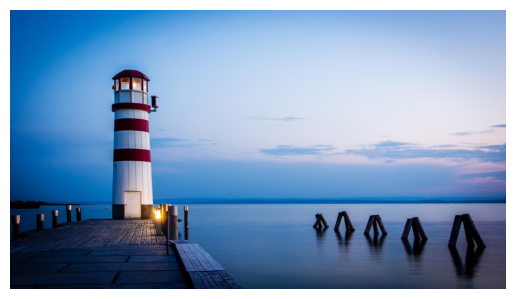

In [166]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/image_with_id.jpg'
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()
